#### Problem 1:

We are interested in knowing on which hour of the day each user is more active. We will need to work on two columns ``author_id`` and ``date_added``.

In [78]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt

In [86]:
%%file codes/active_hour.py 
# this magic command allows saving output of python to folder
from mrjob.job import MRJob
from datetime import datetime
from collections import Counter

class MRJobActiveHour(MRJob):
    
    
    def mapper(self,_,line):
        data = line.strip().split('\t')  # getting each line of the data into a list
        if len(data) == 19 and data[0] != "id": # making sure we are skipping the header
            user = data[3]
            added_at = data[8]
            date_at = added_at[1:20]
            if len(date_at) == 19:
                date_at = datetime.strptime(date_at, "%Y-%m-%d %H:%M:%S")
                hour = date_at.hour
                yield user[1:-1], hour
            
        
    def reducer(self, user, hour):
        hour_list = list(hour)
        hour_freq = Counter(hour_list)
        max_rep = hour_freq.most_common(1)[0][1] #  getting the hour with highest number of activities
        for h, repitition in hour_freq.items():
            if repitition == max_rep:
                yield user, h  # reports the time that has highest activities
        
    
       
if __name__ == '__main__':  
    MRJobActiveHour.run()  # where MRJobCategoryCost is your job class

Overwriting codes/active_hour.py


In [87]:
tic = time()
string =! python codes/active_hour.py data/forum_slice.tsv 
toc = time()

print('Running this query took {} seconds.'.format(toc - tic))
ctr = 0
for s in string: # prining the first 15 line of the output log
    print(s)
    ctr +=1
    if ctr == 15:
        break

Running this query took 3.3507730960845947 seconds.
Using configs in C:\Users\Amin\.mrjob.conf
No configs specified for inline runner
Running step 1 of 1...
Creating temp directory C:\Users\Amin\AppData\Local\Temp\active_hour.Amin.20190304.022112.874727
job output is in C:\Users\Amin\AppData\Local\Temp\active_hour.Amin.20190304.022112.874727\output
Streaming final output from C:\Users\Amin\AppData\Local\Temp\active_hour.Amin.20190304.022112.874727\output...
"100000005"	1
"100000009"	20
"100000058"	16
"100000066"	5
"100000067"	4
"100000071"	4
"100000093"	4
"100000154"	7
"100000162"	14


Now that we have the algorithm prototyped locally, we will run it on total data on cluster. We use this code in the command line:
```
python codes/active_hour.py -r emr s3://mapreduce0000/data/forum_users.tsv --output-dir=s3://mapreduce0000/active_users/
```
  


Here is a snapshot of the results downloaded from AWS.

In [89]:
! head outputs/active_hours_users

"100000000"	9
"100000002"	4
"100000003"	5
"100000005"	1
"100000007"	3
"100000008"	16
"100000009"	20
"100000011"	3
"100000014"	4
"100000016"	23


#### Problem 2:
We are interested in knowing how much is the correlation between question and answer lengths for a single post (defined by ``node_id``)

In [93]:
%%file codes/qacorr.py 
# this magic command allows saving output of python to folder
from mrjob.job import MRJob
#from mr3px.csvprotocol import CsvProtocol # to output in csv format

class MRJobQA(MRJob):
    #OUTPUT_PROTOCOL = CsvProtocol    
    def mapper(self,_,line):
        data = line.strip().split('\t')  # getting each line of the data into a list
        if len(data) == 19 and line[1] != 'i':
            node_id = data[0]
            body = data[4]
            node_type = data[5]
            parent_id = data[6]
            if 'q' in node_type:  # question
                yield node_id, [len(body), node_type]  
            elif 'a' in node_type:
                yield parent_id, [len(body), node_type] 
        
    def reducer(self, node_id, length_type_pack):
        self.length_list = [0,[]]
        for pack in length_type_pack:
            pack[1] = pack[1][1:-1] # remove additional "s
            if pack[1] == 'question':
                self.length_list[0] = pack[0]
            if pack[1] == 'answer':
                self.length_list[1].append(pack[0])
            averages = 0 if len(self.length_list[1]) == 0 else sum(self.length_list[1])/len(self.length_list[1])
        yield None, (node_id[1:-1], self.length_list[0], averages)
        
if __name__ == '__main__':  
    MRJobQA.run()  # where MRJobCategoryCost is your job class

Overwriting codes/qacorr.py


In [75]:
tic = time()
! python codes/qacorr.py data/forum_node.tsv  > test.csv
toc = time()

Using configs in C:\Users\Amin\.mrjob.conf
No configs specified for inline runner
Running step 1 of 1...
Creating temp directory C:\Users\Amin\AppData\Local\Temp\qacorr.Amin.20190304.055708.771395
job output is in C:\Users\Amin\AppData\Local\Temp\qacorr.Amin.20190304.055708.771395\output
Streaming final output from C:\Users\Amin\AppData\Local\Temp\qacorr.Amin.20190304.055708.771395\output...
Removing temp directory C:\Users\Amin\AppData\Local\Temp\qacorr.Amin.20190304.055708.771395...


Code is run on AWS using the following command:

``python codes/qacorr.py -r emr s3://mapreduce0000/data/forum_node.tsv --output-dir=s3://mapreduce0000/csvcorr``

Now let's see if there is any correlation between the question and answer length.

In [90]:
df = pd.read_csv('test.csv', header=-1)
df.columns = ['node_id', 'q_length', 'a_length']
df.set_index('node_id', inplace=True)
boolean_mask = (df['q_length'] !=0) & (df['a_length'] !=0)
df = df[boolean_mask]

Text(0.5,1,'Question length vs corresponding average of response length.')

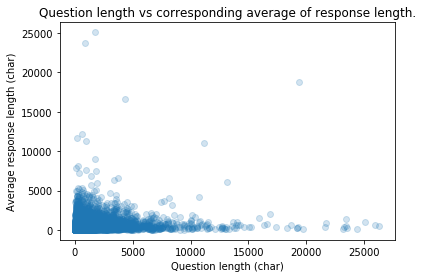

In [91]:
plt.scatter(df['q_length'],df['a_length'], alpha=0.2)
plt.xlabel('Question length (char)')
plt.ylabel('Average response length (char)')
plt.title('Question length vs corresponding average of response length.')

In [92]:
df.corr()

,q_length,a_length
q_length,1.000000,0.164115
a_length,0.164115,1.000000


There is a very small correlation between the length of the questions and answers.

#### Problem 3
We want to check what are the top 10 tags related to questions.

In [122]:
%%file codes/toptags.py 
# this magic command allows saving output of python to folder
from mrjob.job import MRJob
from mrjob.step import MRStep
class MRJobTags(MRJob):
    def mapper(self,_,line):
        data = line.strip().split('\t')  # getting each line of the data into a list
        if len(data) == 19 and line[1] != 'i':
            node_type = data[5]
            tagnames = data[2][1:-1] # tagnames
            tag_list = tagnames.strip().split(' ')
            if 'q' in node_type:  # question
                for tag in tag_list:
                    yield tag, 1
    def combiner(self, tag, count)                    :
        yield tag, sum(count)
        
    def reducer_counter(self, tag, sum_count):
        yield None, (sum(sum_count),tag)  # reducer return all the couts with the same key
        
    def reducer_final(self, _, count_tag_pack):
        self.toplist = []
        for pack in count_tag_pack:
            self.toplist.append(pack)
        pack_list = sorted(self.toplist, reverse=True)[:10]
        for p in pack_list:
            yield p[1], p[0]
            
            
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                  combiner=self.combiner,
                  reducer=self.reducer_counter),
            MRStep(reducer=self.reducer_final)
        ]
if __name__ == '__main__':  
    MRJobTags.run()  # where  is your job class                    

Overwriting codes/toptags.py


In [123]:
tic = time()
! python codes/toptags.py data/sample.tsv
toc = time()

"cs101"	837
"homework"	139
"python"	48
"bug"	45
"unit2"	29
"quiz"	28
"hw2.6"	27
"question"	23
"hw1.9"	21
"help"	20


Using configs in C:\Users\Amin\.mrjob.conf
No configs specified for inline runner
Running step 1 of 2...
Creating temp directory C:\Users\Amin\AppData\Local\Temp\toptags.Amin.20190305.051610.441093
Running step 2 of 2...
job output is in C:\Users\Amin\AppData\Local\Temp\toptags.Amin.20190305.051610.441093\output
Streaming final output from C:\Users\Amin\AppData\Local\Temp\toptags.Amin.20190305.051610.441093\output...
Removing temp directory C:\Users\Amin\AppData\Local\Temp\toptags.Amin.20190305.051610.441093...


Let's run it on AWS for the whole forum data.

> ``python codes/toptags.py -r emr s3://mapreduce0000/data/forum_node.tsv --output-dir=s3://mapreduce0000/outputs/toptags``

Results downloaded from AWS s3:

In [124]:
! cat outputs/toptags

"cs101"	11621
"cs373"	4952
"cs253"	4542
"discussion"	3560
"meta"	2664
"cs212"	2009
"homework"	1682
"bug"	1651
"cs262"	1561
"st101"	1489
